In [1]:
# This is only needed if the notebook is run in VSCode
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch


# OR-ELM: Online Recurrent Extreme Learning Machine for time-series prediction

> This notebook applies visual analytics to [OR_ELM](https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine) algorithm

In [2]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
import wandb
wandb_api = wandb.Api()
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *
import nbs.orelm_torch as orelm

/home/macu/lib/orelm/
El directorio existe: /home/macu/lib/orelm/
['/home/macu/work/nbs_pipeline', '/home/macu/env/lib/python310.zip', '/home/macu/env/lib/python3.10', '/home/macu/env/lib/python3.10/lib-dynload', '', '/home/macu/env/lib/python3.10/site-packages', '/home/macu/env/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/macu/lib/tsai', '/home/macu/work']
['/home/macu/work/nbs_pipeline', '/home/macu/env/lib/python310.zip', '/home/macu/env/lib/python3.10', '/home/macu/env/lib/python3.10/lib-dynload', '', '/home/macu/env/lib/python3.10/site-packages', '/home/macu/env/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/macu/lib/tsai', '/home/macu/work', '/home/macu/lib/orelm/']


For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

## Notebook configuration

In [3]:
import nbs_pipeline.utils.config as cfg
config, job_type = cfg.get_artifact_config_ORELM(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/02c-encoder_orelm.yaml
... About to replace includes with content
Before configuration reading 
-include: None
-user_preferences:
	-use_wandb: False
	-wdb:
		-user: mi-santamaria
		-project_name: test-project
		-version: 0
		-mode: offline
		-artifacts_path: ./data/wandb_artifacts
	-data:
		-folder: ~/data/
		-fname: Semantic_Segmentation_TiltABP
		-ftype: .csv
		-cols: []
		-freq: 1s
	-artifact:
		-alias: TiltABP
	-directories:
		-tmp: tmp
		-data: ~/data/Semantic_Segmentation_TiltABP.csv
-data:
	-name: Semantic_Segmentation_TiltABP
	-path: ~/data/Semantic_Segmentation_TiltABP.csv
	-alias: TiltABP
	-cols: []
	-csv_config:
	-date_offset: None
	-date_format: %Y-%m-%d %H:%M:%S
	-freq: 1s
	-joining_train_test: False
	-missing_values:
		-technique: None
		-constant: None
	-normalize_training: False
	-range_training: None
	-range_testing: None
	-resampling_freq: None
	-start_date: None
	-test_split: None
	-time_col: None
-wandb:
	-user: mi

In [4]:
print("Project: "+config.wandb_project)
run = wandb.init(
    entity          = config.wandb_entity,
    project         = config.wandb_project,
    group           = config.wandb_group,
    job_type        = job_type,
    allow_val_change= True,
    mode            = 'online' if config.use_wandb else 'disabled',
    config          = config,
    resume          = False
)
config = run.config  # Object for storing hyperparameters
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

Project: test-project


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Loading the datasets

To load the dataset we will download a specific dataset artifact from the collection of artifacts
stored in the weights and biases (wandb) project associated to this experiment.

### Sliding window features

Define a continuous multivariate time-series data $D$ of dimension $d$ with $n$ time-steps, $D = X_1,X_2,\dots,X_n$ , where each $X_i = \{x_i^1,\dots,x_i^d\}$ . Let $w$ be the window width, $s$ the stride, and $t$ the start time of a sliding window in the data.

Define a new matrix $Z_k$ where each row is a vector of size $w$ of data extracted from the $k^{th}$ dimension.

\begin{aligned}&Z_k(w,s,t)\\&\quad =\begin{bmatrix} x_{t}^k&\quad x_{t+1}^k&\quad \dots&\quad x_{t+w-1}^k \\ x_{t+s}^k&\quad x_{t+s+1}^k&\quad \dots&\quad x_{t+s+w-1}^k \\ \vdots&\quad \vdots&\quad \ddots&\quad \vdots \\ x_{t+(r-1)s}^k&\quad x_{t+(r-1)s+1}^k&\quad \dots&\quad x_{t+(r-1)s+w-1}^k \end{bmatrix} \end{aligned}

where $r$ is the number of desired rows, and $t+(r-1)s+w-1 \le n$


$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [5]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [6]:
train_artifact = artifacts_gettr(config.train_artifact)
df_train = train_artifact.to_df()
X_train, _ = sw(df_train)
df_train.shape, X_train.shape

wandb:   1 of 1 files downloaded.  


((40000, 2), (39969, 2, 32))

In [7]:
if config.valid_artifact:
    valid_artifact = artifacts_gettr(config.valid_artifact)
    df_val = valid_artifact.to_df()
    X_valid, _ = sw(df_val)
    df_val.shape, X_valid.shape

## TODO: METER EXPLICACIÓN DE OR-ELM


todo: AQUI VA LA EXPLICACIÓN CON EL EJEMPLO QUE SE META EN EL PAPER

### Create the model

In [8]:
random.seed = config.random_seed

m = orelm.ORELM_torch(
    inputs                      = X_train.shape[1],
    outputs                     = 1,
    numHiddenNeurons            = config.numHiddenNeurons, #X_train.shape[1], #config.numHiddenNeurons,
    activationFunction          = config.activationFunction,
    LN                          = config.LN,
    AE                          = config.AE,
    ORTH                        = config.ORTH,
    inputWeightForgettingFactor = config.inputWeightForgettingFactor,
    outputWeightForgettingFactor= config.outputWeightForgettingFactor
)
print(m)

inputs
2
outputs
1
numNeurons
25
Out weight FF
0.92
(25, 2)
ORELM_torch()


Train the model with fastai Learner class, to abstract from Pytorch's training loop

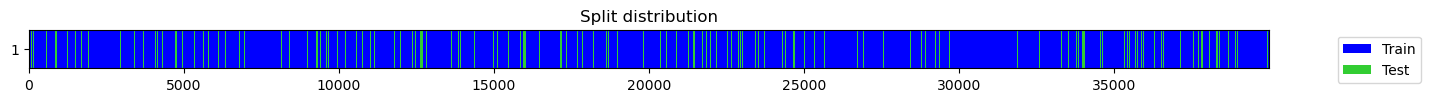

((#35973) [19678,10307,27582,18546,33815,6637,6520,20692,39334,9424...],
 (#3996) [886,6291,15984,272,15035,13138,20624,27497,38163,37592...])

In [9]:
if config.valid_artifact:
    X, y, splits  = combine_split_data(xs=[X_train, X_valid], ys=[X_train, X_valid])
else:
    X = X_train
    y = X_train
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
splits

(<Axes: >, <Axes: >)

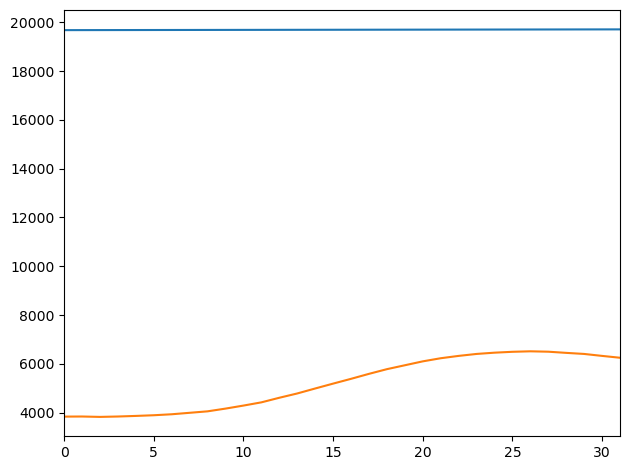

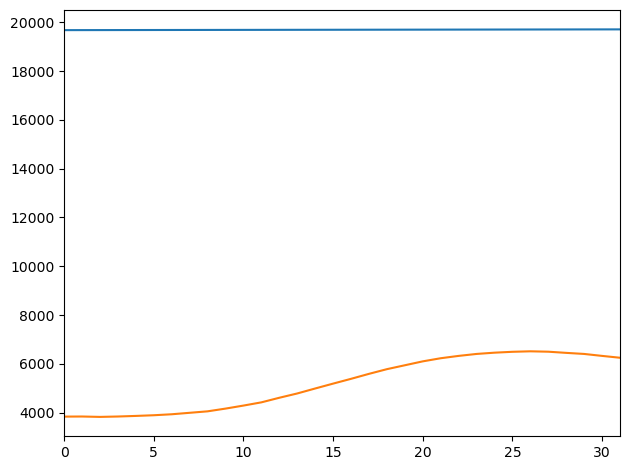

In [10]:
tfms = [ToFloat(), ToFloat()]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.dataset[0][0].show(), ToTSTensor()(dls.dataset[0][1]).show()




To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

Finally, log the learner to be used by the next notebook in the pipeline

In [11]:
print(dls.dataset)

(#35973) [(TSTensor(vars:2, len:32, device=cpu, dtype=torch.float32), tensor([[19678., 19679., 19680., 19681., 19682., 19683., 19684., 19685., 19686.,
         19687., 19688., 19689., 19690., 19691., 19692., 19693., 19694., 19695.,
         19696., 19697., 19698., 19699., 19700., 19701., 19702., 19703., 19704.,
         19705., 19706., 19707., 19708., 19709.],
        [ 3840.,  3844.,  3828.,  3844.,  3868.,  3896.,  3936.,  3996.,  4056.,
          4168.,  4292.,  4424.,  4612.,  4788.,  4992.,  5192.,  5388.,  5592.,
          5784.,  5944.,  6104.,  6232.,  6328.,  6408.,  6460.,  6496.,  6516.,
          6500.,  6452.,  6408.,  6328.,  6252.]])), (TSTensor(vars:2, len:32, device=cpu, dtype=torch.float32), tensor([[10307., 10308., 10309., 10310., 10311., 10312., 10313., 10314., 10315.,
         10316., 10317., 10318., 10319., 10320., 10321., 10322., 10323., 10324.,
         10325., 10326., 10327., 10328., 10329., 10330., 10331., 10332., 10333.,
         10334., 10335., 10336., 10337

# COPIANDO ORIGINAL ANTES DE TRADUCIR A WANDB (me he hecho un lío)

In [12]:
#dataSet = 'speed_6005'
dataSet = 'nyc_taxi'
filePath = '~/data/'+dataSet+'.csv'
print(filePath)
df = pd.read_csv(filePath, header=0, skiprows=[1,2], names=['time', 'data', 'timeofday', 'dayofweek'])
#df = pd.read_csv(filePath, header=1, skiprows=[], names=['timestamp', 'data'])
df.head(5)
print(df['data'])

~/data/nyc_taxi.csv
0        10844
1         8127
2         6210
3         4656
4         3820
         ...  
17515    20223
17516    19967
17517    18865
17518    16893
17519    14242
Name: data, Length: 17520, dtype: int64


In [13]:
df.info()
print(df['data'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   time       17520 non-null  object
 1   data       17520 non-null  int64 
 2   timeofday  17520 non-null  int64 
 3   dayofweek  17520 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 547.6+ KB
0        10844
1         8127
2         6210
3         4656
4         3820
         ...  
17515    20223
17516    19967
17517    18865
17518    16893
17519    14242
Name: data, Length: 17520, dtype: int64


In [14]:
df.isnull().sum()
print(df['data'])

0        10844
1         8127
2         6210
3         4656
4         3820
         ...  
17515    20223
17516    19967
17517    18865
17518    16893
17519    14242
Name: data, Length: 17520, dtype: int64


In [15]:
# standardize data by subtracting mean and dividing by std
print(df['data'])
meanSeq     = np.mean(df['data'])
print(meanSeq)
stdSeq      = np.std(df['data'])
print(stdSeq)
df['data'] = (df['data'] - meanSeq)/stdSeq
df.head()

0        10844
1         8127
2         6210
3         4656
4         3820
         ...  
17515    20223
17516    19967
17517    18865
17518    16893
17519    14242
Name: data, Length: 17520, dtype: int64
15075.67305936073
6821.07994049619


,time,data,timeofday,dayofweek
0,2014-07-01 00:00:00,-0.620382,0,1
1,2014-07-01 00:30:00,-1.018706,30,1
2,2014-07-01 01:00:00,-1.299746,60,1
3,2014-07-01 01:30:00,-1.527569,90,1
4,2014-07-01 02:00:00,-1.650131,120,1


### Prepare input-target pairs

In [16]:
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1):
  print("generate time embedded matrix")
  inDim = numLags
  X = np.zeros(shape=(len(sequence), inDim))
  T = np.zeros(shape=(len(sequence), 1))
  for i in range(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence['data'][(i-numLags+1):(i+1)])
    T[i, :] = sequence['data'][i+predictionStep]
  print('input shape: ',X.shape)
  print('target shape: ',T.shape)
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(df, numLags = 100, predictionStep = 5)
print(X.shape, T.shape)

generate time embedded matrix
input shape:  (17520, 100)
target shape:  (17520, 1)
(17520, 100) (17520, 1)


In [20]:
def linear_recurrent(features, inputW,hiddenW,hiddenA, bias):
  V = np.dot(features, np.transpose(inputW)) + np.dot(hiddenA,hiddenW) + bias
  return V

def layerNormalization(H, scaleFactor=1, biasFactor=0):

  H_normalized = (H-H.mean())/(np.sqrt(H.var() + 0.000001))
  H_normalized = scaleFactor*H_normalized+biasFactor

  return H_normalized

nDimInput       = 100
nDimOutput      = 1
numNeurons      = config.numHiddenNeurons #25
algorithm       = 'OSELM'
LN              = True 
InWeightFF      = 1.0
OutWeightFF     = config.outputWeightForgettingFactor #0.92
HiddenWeightFF  = config.inputWeightForgettingFactor #1.0
AE              = True
lamb            = 0.0001

inputW      = np.random.random((20,nDimInput))
hiddenW     = np.random.random((20,20))
hiddenA     = np.random.random((1,20))
bias        = np.random.random((1,20)) * 2 -1
features    = np.random.random((1,nDimInput))
hidden      = linear_recurrent(features,inputW,hiddenW,hiddenA,bias)
hidden      = layerNormalization(hidden)

print('input_weights:',inputW.shape)
print('hidden_weights:',hiddenW.shape)
print('bias:', bias.shape)
print('input features:', features.shape)
print('hidden:',hidden.shape)
print('hidden:',hidden.shape)

input_weights: (20, 100)
hidden_weights: (20, 20)
bias: (1, 20)
input features: (1, 100)
hidden: (1, 20)
hidden: (1, 20)


In [21]:
m = orelm.ORELM_torch(
    inputs                      = nDimInput,
    outputs                     = nDimOutput,
    numHiddenNeurons            = numNeurons, #X_train.shape[1], #config.numHiddenNeurons,
    #activationFunction          = config.activationFunction,
    #LN                          = config.LN,
    #AE                          = config.AE,
    #ORTH                        = config.ORTH,
    #inputWeightForgettingFactor = InWeightFF,
    outputWeightForgettingFactor= OutWeightFF
)
m.initializePhase(lamb=0.0001)

inputs
100
outputs
1
numNeurons
25
Out weight FF
0.92
(25, 100)


In [22]:
predictions= []
target= []
numLags = 100
predictionStep = 5
for i in range(numLags, len(df)-predictionStep-1):
    m.train(X[[i], :], T[[i], :])
    Y = m.predict(X[[i+1], :])
    predictions.append(Y[0][0])
    target.append(T[i][0])
    print ("{:5}th timeStep -  target: {:8.4f}   |    prediction: {:8.4f} ".format(i, target[-1], predictions[-1]))

  100th timeStep -  target:  -1.7591   |    prediction:  -1.6793 
  101th timeStep -  target:  -1.7703   |    prediction:  -1.7694 
  102th timeStep -  target:  -1.5370   |    prediction:  -1.3486 
  103th timeStep -  target:  -1.2593   |    prediction:  -1.1404 
  104th timeStep -  target:  -0.7275   |    prediction:  -0.5222 
  105th timeStep -  target:  -0.4157   |    prediction:  -0.3228 
  106th timeStep -  target:  -0.0735   |    prediction:  -0.0660 
  107th timeStep -  target:   0.2496   |    prediction:   0.4287 
  108th timeStep -  target:   0.5621   |    prediction:   0.4408 
  109th timeStep -  target:   0.4800   |    prediction:   0.3494 
  110th timeStep -  target:   0.3141   |    prediction:   0.3445 
  111th timeStep -  target:   0.1497   |    prediction:  -0.0810 
  112th timeStep -  target:   0.1955   |    prediction:   0.0343 
  113th timeStep -  target:   0.1198   |    prediction:  -0.0047 
  114th timeStep -  target:   0.2496   |    prediction:   0.2679 
  115th ti

# Evaluation: Calculate total Normalizedd Root Mean Square Error (NRMSE)

In [23]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  
def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

NRMSE 0.19523920180110987


## Plot predictions and target values

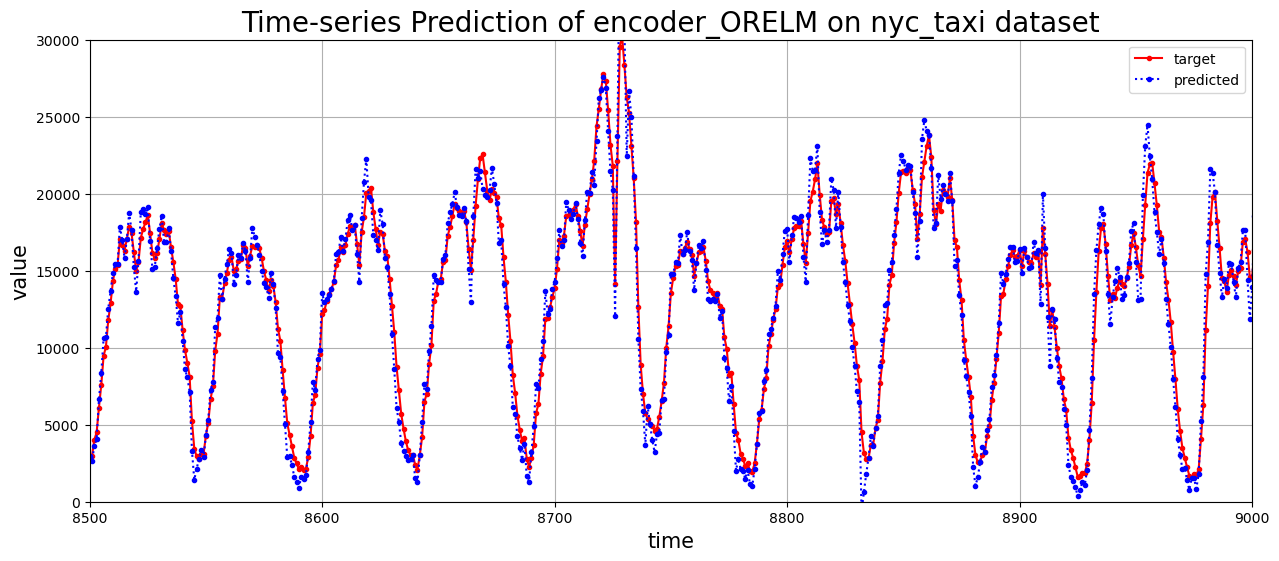

Prediction plot is saved to./predictionPlot.png


In [25]:
algorithm = config.job_type
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([8500,9000])
plt.ylim([0, 30000])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.savefig(plot_path,bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)

## Online learning and prediction of OR-ELM

In [ ]:
run.finish()